In [ ]:
from typing import *
from sklearn.pipeline import Pipeline
from pandas import DataFrame
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

def run_experiment(clf_pipelines: Pipeline,
                   df: DataFrame,
                   predict_periods: bool = True,
                   pipeline_infos: List[str] = None,
                   train_period: str = 'P1',
                   random_state: int =42,
                   test_size: float = 0.2,
                   bar_width: float = 0.35,
                   verbose: bool = False) -> plt.Figure:
    
    # 0. Init figure
    fig, ax = plt.subplots()
    
    if not pipeline_infos:
        pipeline_infos = [None for i in clf_pipelines]
    
    if verbose:
        iterator = tqdm_notebook(zip(clf_pipelines, pipeline_infos))
    else:
        iterator = zip(clf_pipelines, pipeline_infos)
    
    for clf_pipeline, pipeline_info in iterator:
    
        # 0.1 Some preperations
        if not pipeline_info:
            pipeline_info = clf_pipeline.steps[-1][0]
        if predict_periods:
            # 1. Train on all periods, predict all periods
            df_train, df_test = train_test_split(df, random_state=random_state, test_size=test_size)


            clf_pipeline.fit(df_train.text, df_train.period)
            y_pred = clf_pipeline.predict(df_test.text)
            report = classification_report(df_test.period, y_pred, output_dict=True)

            score_per_class = {}
            for class_label in list(report.keys())[:-3]:
                score_per_class[class_label] = report[class_label]

            x = np.arange(len(score_per_class))
            ax.bar(x + bar_width/2,
                   [v['f1-score'] for v in score_per_class.values()],
                   label=f'{pipeline_info} trained on Periods')#, 'g-')
            ax.set_xticklabels(score_per_class.keys())

            del df_test  # due to consistency


        # train on one period predict the others

        df_train = df[df.period == train_period]
        df_rest = df[df.period != train_period] # mabe use this df laterone
        test_periods = [df[df.period == p] for p in sorted(df.period.unique())]

        # fit pipe

        clf_pipeline.fit(df_train.text, df_train.genre)

        test_periods_labels = []  # for plotting
        fscores = [] 
        for test_period in test_periods:

            # save period label to label for plotting
            test_periods_labels.append(test_period.period.unique()[0])

            y_pred = clf_pipeline.predict(test_period.text)


            fscores.append(f1_score(test_period.genre, y_pred, average='macro'))


        ax.plot(test_periods_labels, fscores, label=f'{pipeline_info} trained on genres in period {train_period}', zorder=1)
        ax.legend()
    
    ax.set_xlabel('Periods')
    ax.set_ylabel('F1-Score')
    fig.tight_layout()
    return fig, ax
    

In [ ]:
from typing import *
from sklearn.pipeline import Pipeline
from pandas import DataFrame
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

def run_experiment_region(clf_pipelines: Pipeline,
                   df: DataFrame,
                   predict_region: bool = True,
                   pipeline_infos: List[str] = None,
                   train_region: str = 'WMD',
                   random_state: int =42,
                   test_size: float = 0.2,
                   bar_width: float = 0.35,
                   verbose: bool = False) -> plt.Figure:
    
    # 0. Init figure
    fig, ax = plt.subplots()
    
    if not pipeline_infos:
        pipeline_infos = [None for i in clf_pipelines]
    
    if verbose:
        iterator = tqdm_notebook(zip(clf_pipelines, pipeline_infos))
    else:
        iterator = zip(clf_pipelines, pipeline_infos)
    
    for clf_pipeline, pipeline_info in iterator:
    
        # 0.1 Some preperations
        if not pipeline_info:
            pipeline_info = clf_pipeline.steps[-1][0]
        if predict_region:
            # 1. Train on all region, predict all region
            df_train, df_test = train_test_split(df, random_state=random_state, test_size=test_size)


            clf_pipeline.fit(df_train.text, df_train.region)
            y_pred = clf_pipeline.predict(df_test.text)
            report = classification_report(df_test.region, y_pred, output_dict=True)

            score_per_class = {}
            for class_label in list(report.keys())[:-3]:
                score_per_class[class_label] = report[class_label]

            x = np.arange(len(score_per_class))
            ax.bar(x + bar_width/2,
                   [v['f1-score'] for v in score_per_class.values()],
                   label=f'{pipeline_info} trained on region')#, 'g-')
            ax.set_xticklabels(score_per_class.keys())

            del df_test  # due to consistency


        # train on one region predict the others

        df_train = df[df.region == train_region]
        df_rest = df[df.region != train_region] # mabe use this df laterone
        
        # sort region labels so that the train region will be first 
        test_region_labels = df.region.unique().tolist()
        # swap train region to first place in list
        ind = test_region_labels.index(train_region)
        temp = test_region_labels[0]
        test_region_labels[0] = test_region_labels[ind]
        test_region_labels[ind] = temp
        
        test_region = [df[df.region == p] for p in test_region_labels]
        
        

        # fit pipe

        clf_pipeline.fit(df_train.text, df_train.genre)

        test_region_labels = []  # for plotting
        fscores = [] 
        for test_region in test_region:

            # save region label to label for plotting
            test_region_labels.append(test_region.region.unique()[0])

            y_pred = clf_pipeline.predict(test_region.text)


            fscores.append(f1_score(test_region.genre, y_pred, average='macro'))


        ax.plot(test_region_labels, fscores, label=f'{pipeline_info} trained on genres in region {train_region}', zorder=1)
        ax.legend()
    
    ax.set_xlabel('region')
    ax.set_ylabel('F1-Score')
    #fig.tight_layout()
    return fig, ax
    

In [117]:
def run_exp_region_genre(
    clf_pipelines: Pipeline,
    df: DataFrame,
    pipeline_infos: List[str] = None,
    train_region: str = 'WMD',
    verbose: bool = False):
    
    # init figure
    fig, ax = plt.subplots(figsize=(7,7))
    NUM_COLORS = len(df.genre.unique()) * len(clf_pipelines)
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    #ax.set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    if not pipeline_infos:
        pipeline_infos = [None for i in clf_pipelines]
    
    # build trainset
    df_train = df[df.region == train_region]
    
    
    # build testset
    # sort region labels so that the train region will be first 
    test_region_labels = df.region.unique().tolist()
    # swap train region to first place in list
    ind = test_region_labels.index(train_region)
    temp = test_region_labels[0]
    test_region_labels[0] = test_region_labels[ind]
    test_region_labels[ind] = temp

    test_regions = [df[df.region == p] for p in test_region_labels]
    
    # loop over all pipes
    if verbose:
        iterator = tqdm_notebook(zip(clf_pipelines, pipeline_infos))
    else:
        iterator = zip(clf_pipelines, pipeline_infos)
    
    for clf_pipeline, pipeline_info in iterator:
        
        # 0.1 Some preperations
        if not pipeline_info:
            pipeline_info = clf_pipeline.steps[-1][0]
        
        # fit clf_pipeline
        clf_pipeline.fit(df_train.text, df_train.genre)
        
        for genre in df.genre.unique():
        
            # init fscores
            fscores = []

            # loop over all regions
            for df_region in test_regions:

                current_region = df_region.region.unique()[0]

                y_pred = clf_pipeline.predict(df_region.text)

                report = classification_report(df_region.genre, y_pred, output_dict=True)
                if report.get(genre):
                    fscores.append(report[genre]['f1-score'])
                else:
                    fscores.append(0)

            ax.plot(test_region_labels, fscores, label=f'{pipeline_info} {genre} {train_region}', zorder=1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Region')
    ax.set_ylabel('F1-Score')
    return fig, ax
    
    

In [118]:
def run_exp_period_genre(
    clf_pipelines: Pipeline,
    df: DataFrame,
    pipeline_infos: List[str] = None,
    train_period: str = 'WMD',
    verbose: bool = False):
    
    # init figure
    fig, ax = plt.subplots(figsize=(7,7))
    NUM_COLORS = len(df.genre.unique()) * len(clf_pipelines)
    cm = plt.get_cmap('gist_rainbow')
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    #ax.set_color_cycle()
    
    if not pipeline_infos:
        pipeline_infos = [None for i in clf_pipelines]
    
    # build trainset
    df_train = df[df.period == train_period]
    
    
    # build testset
    # sort period labels so that the train period will be first 
    test_period_labels = sorted(df.period.unique().tolist())
    # swap train period to first place in list
    ind = test_period_labels.index(train_period)
    temp = test_period_labels[0]
    test_period_labels[0] = test_period_labels[ind]
    test_period_labels[ind] = temp

    test_period = [df[df.period == p] for p in test_period_labels]
    
    # loop over all pipes
    if verbose:
        iterator = tqdm_notebook(zip(clf_pipelines, pipeline_infos))
    else:
        iterator = zip(clf_pipelines, pipeline_infos)
    
    for clf_pipeline, pipeline_info in iterator:
        
        # 0.1 Some preperations
        if not pipeline_info:
            pipeline_info = clf_pipeline.steps[-1][0]
        
        # fit clf_pipeline
        clf_pipeline.fit(df_train.text, df_train.genre)
        
        for genre in df.genre.unique():
        
            # init fscores
            fscores = []

            # loop over all period
            for df_period in test_period:

                current_period = df_period.period.unique()[0]

                y_pred = clf_pipeline.predict(df_period.text)

                report = classification_report(df_period.genre, y_pred, output_dict=True)
                if report.get(genre):
                    fscores.append(report[genre]['f1-score'])
                else:
                    fscores.append(0)

            ax.plot(test_period_labels, fscores, label=f'{pipeline_info} {genre} {train_period}', zorder=1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Period')
    ax.set_ylabel('F1-Score')
    return fig, ax
    
    

In [115]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from stop_words import get_stop_words

#pipe1 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), LogisticRegression())
pipe2 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), LinearSVC())
pipe3 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), MultinomialNB())
#pipe4 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), DecisionTreeClassifier())
#pipe5 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), RandomForestClassifier())
#pipe6 = make_pipeline(TfidfVectorizer(stop_words=get_stop_words('de'), max_features=20000), XGBClassifier())




pipes = [pipe2, pipe3]#, pipe4, pipe5]#, pipe6]

In [ ]:
fig, ax = run_experiment(pipes, df, predict_periods=False, verbose=True)

In [ ]:
fig.savefig('test_period.png')

AttributeError: 'numpy.ndarray' object has no attribute 'count'

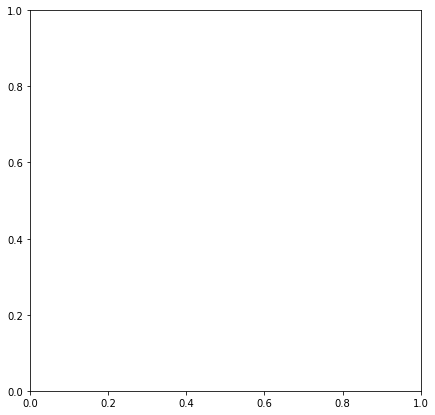

In [111]:
fig, ax = run_exp_region_genre(pipes, df, train_region='NOD', verbose=True)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

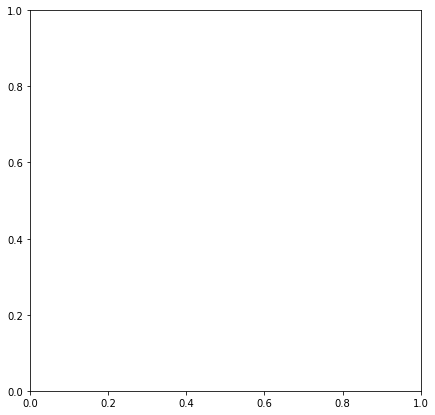

In [112]:
fig, ax = run_exp_period_genre(pipes, df, train_period='P1', verbose=True)

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


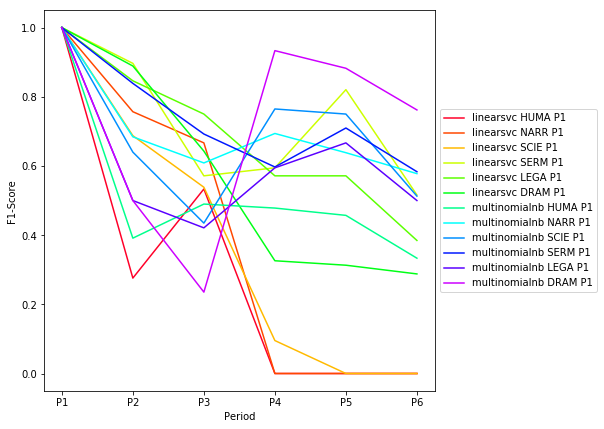

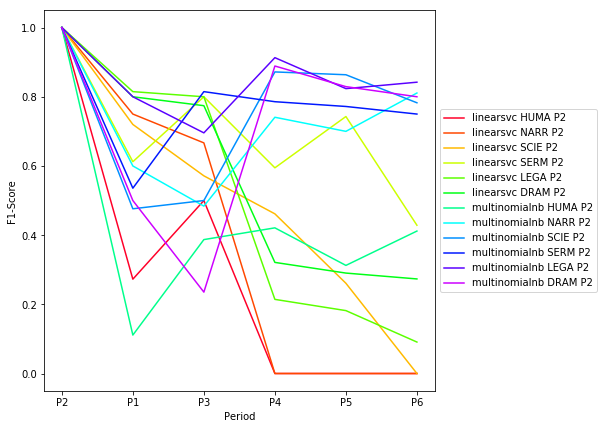

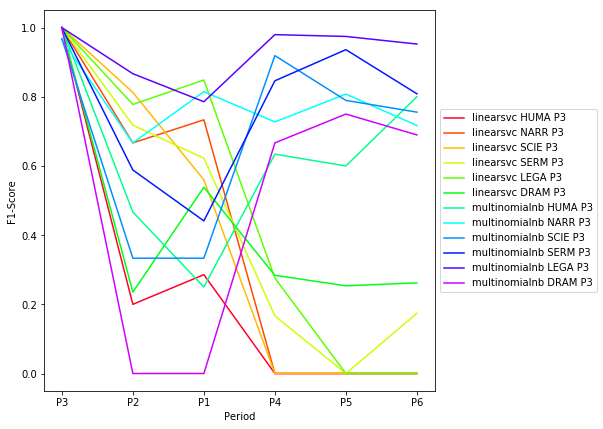

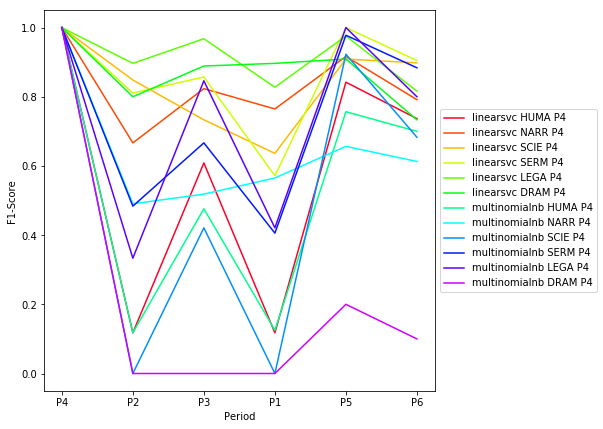

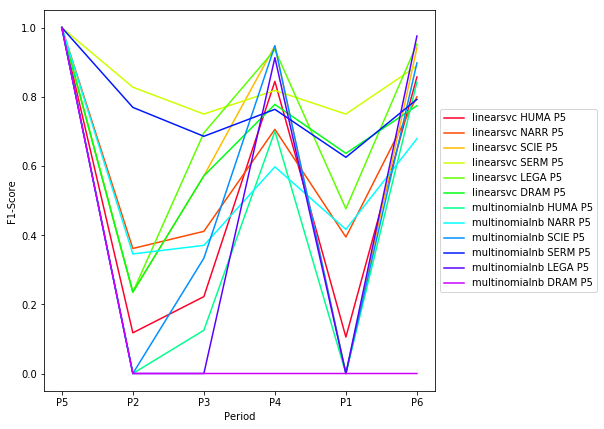

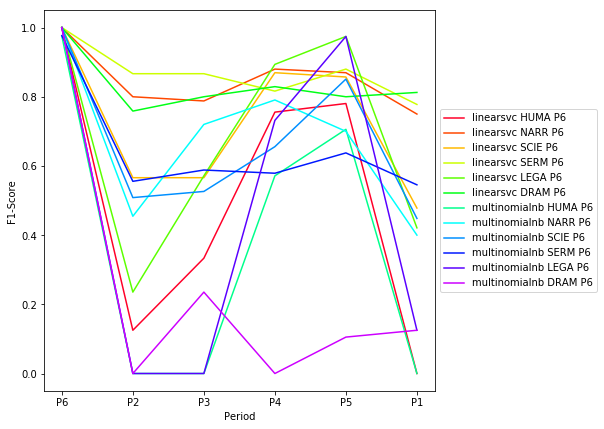

In [119]:
for p in [f'P{i}' for i in range(1,7)]:
    fig, ax = run_exp_period_genre(pipes, df, train_period=p, verbose=True)
    fig.savefig(f'plots/t_{p}.png', dpi=200, bbox_inches='tight')

/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/lennartkeller/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


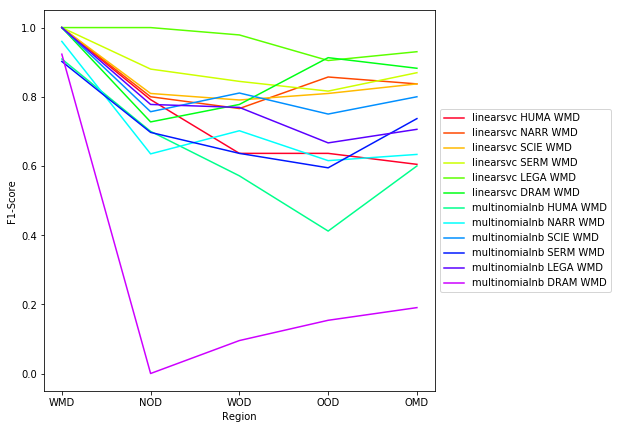

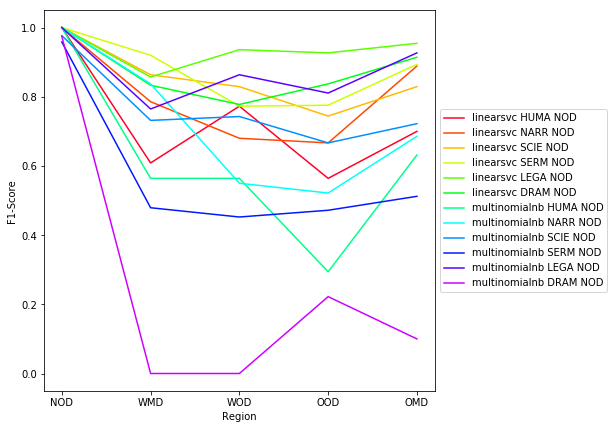

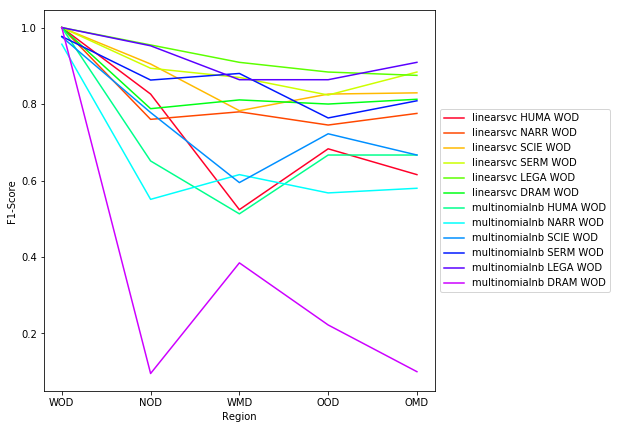

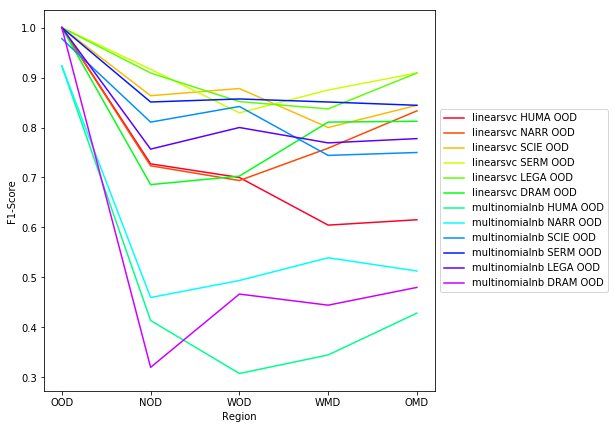

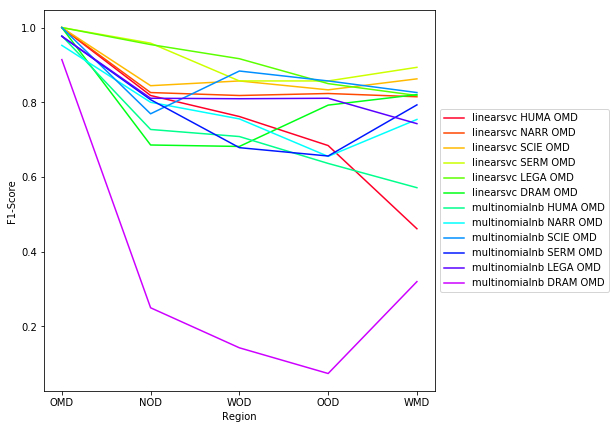

In [120]:
for r in ['WMD', 'NOD', 'WOD', 'OOD', 'OMD']:
    fig, ax = run_exp_region_genre(pipes, df, train_region=r, verbose=True)
    fig.savefig(f'plots/t_{r}.png', dpi=200, bbox_inches='tight')